In [35]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
import matplotlib.pyplot as plt
import numpy as np

In [36]:
class MoneyAgent(Agent):
    "Agent with a fix initial wealth"
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def step(self):
        #print("Hi, Im agent" + str(self.unique_id) + "!")
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

In [37]:
class MoneyModel(Model):
    "The model with some agents"
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        "Create N agents"
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
    def step(self):
        self.schedule.step()

(array([422., 318., 150.,  74.,  23.,  13.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

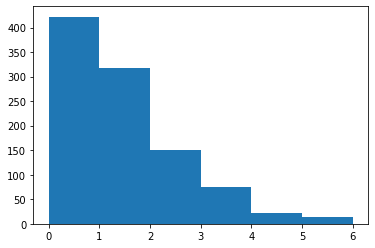

In [38]:
all_wealth = []
for j in range(100):
    money_model = MoneyModel(10)
    for i in range(10):
        money_model.step()
        
    for agent in money_model.schedule.agents:
        all_wealth.append(agent.wealth)
        
plt.hist(all_wealth, bins=range(max(all_wealth)+1))

# Adding Space Distances


In [39]:
class MoneyAgent(Agent):
    "Agent with a fix initial wealth"
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
        self.pos,
        moore = True,
        include_center = False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1
        
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [40]:
class MoneyModel(Model):
    "The model with some agents"
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        "Create N agents"
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a,(x,y))
            
    def step(self):
        self.schedule.step()

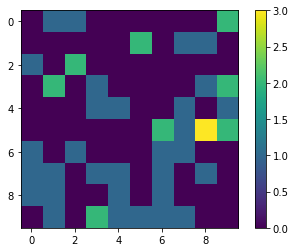

In [41]:
model = MoneyModel(50,10,10)
for i in range(20):
    model.step()
    
agent_counts = np.zeros((model.grid.width,model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

# Collecting Data

In [48]:
def compute_gini(model):
    agent_whealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_whealths)
    N = model.num_agents
    B = sum(xi*(N-i) for i, xi in enumerate(x))/(N*sum(x))
    return (1+(1/N)-2*B)

In [49]:
class MoneyAgent(Agent):
    "Agent with a fix initial wealth"
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
        self.pos,
        moore = True,
        include_center = False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1
        
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [50]:
class MoneyModel(Model):
    "The model with some agents"
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        "Create N agents"
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a,(x,y))
            
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"}
        )
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

<AxesSubplot:>

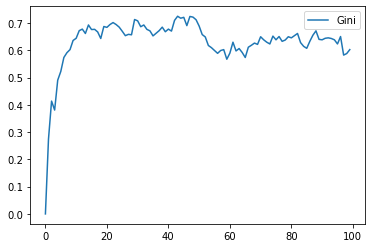

In [51]:
model = MoneyModel(50,10,10)
for i in range(100):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [52]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

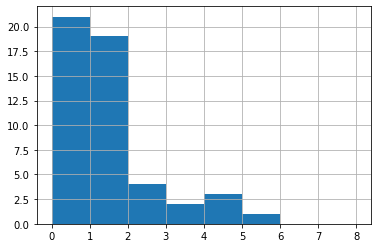

In [53]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

<AxesSubplot:xlabel='Step'>

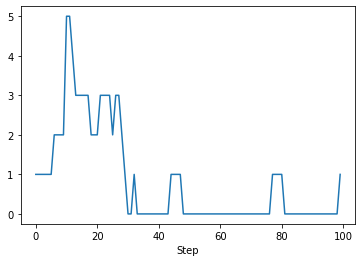

In [54]:
# Agent 14
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()